# Monte Carlo Simulation

In [1]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from datetime import datetime, timedelta

load_dotenv()

%matplotlib inline

In [2]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

## Fetch Tickers Data

In [3]:
def get_ticker_prices(ticker):
    
    # Set timeframe to '1D'
    timeframe = '1Day'
    
    # Create a 30 day time frame
    # Set current date and the date from one month ago using the ISO format
    # NOTE: The free version of Alpaca prohibhits querying the most recent few minutes of data
    # Hence, the subtraction of ~30 minutes via (timedelta(.015))
    current_date = pd.Timestamp(datetime.now() - timedelta(.015), tz="America/New_York").isoformat()
    past_date = pd.Timestamp(datetime.now()- timedelta(30), tz="America/New_York").isoformat()
    
    # Make the API call and store in DataFrame    
    data_df = api.get_bars(
        ticker,
        timeframe,
        start=past_date,
        end=current_date
    ).df
    
    # Clean DataFrame to show only close prices 
    data_df=data_df['close']
    
    return data_df

In [4]:
# Obtain ticker prices, join data and display preview
spy_data = get_ticker_prices("SPY")
agg_data = get_ticker_prices("AGG")
tickers_data = pd.concat([spy_data, agg_data], axis=1, keys=["SPY","AGG"])
tickers_data.head()

SPY     AGG
timestamp                                
2022-04-13 04:00:00+00:00  443.31  104.82
2022-04-14 04:00:00+00:00  437.79  103.97
2022-04-18 04:00:00+00:00  437.97  103.65
2022-04-19 04:00:00+00:00  445.04  103.02
2022-04-20 04:00:00+00:00  444.71  103.61

## Monte Carlo Simulation Code

In [5]:
# Calculate the daily roi for the stocks
daily_returns = tickers_data.pct_change()
print("*" * 100)
print("Daily ROI")
print("*" * 100)
display(daily_returns.head())

# volatility
daily_volatility = daily_returns.std()
spy_volatility = daily_volatility["SPY"]
agg_volatility = daily_volatility["AGG"]

# Save the last day's closing price
spy_last_price = tickers_data["SPY"][-1]
agg_last_price = tickers_data["AGG"][-1]



****************************************************************************************************
Daily ROI
****************************************************************************************************


SPY       AGG
timestamp                                    
2022-04-13 04:00:00+00:00       NaN       NaN
2022-04-14 04:00:00+00:00 -0.012452 -0.008109
2022-04-18 04:00:00+00:00  0.000411 -0.003078
2022-04-19 04:00:00+00:00  0.016143 -0.006078
2022-04-20 04:00:00+00:00 -0.000742  0.005727

In [6]:
# Setup the Monte Carlo Parameters
number_simulations = 10
number_records = 252 * 30  # Years to retirement
monte_carlo = pd.DataFrame()



In [7]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):

    print(f"Running Simulation {x}...")

    # Create the initial simulated prices array seeded with the last closing price
    spy_prices = [spy_last_price]
    agg_prices = [agg_last_price]

    # Simulate the returns for 20 years
    for iteration in range(number_records):
        spy_prices.append(
            spy_prices[-1]
            * (1 + np.random.normal(daily_returns.mean()["SPY"], spy_volatility))
        )
        agg_prices.append(
            agg_prices[-1]
            * (1 + np.random.normal(daily_returns.mean()["AGG"], agg_volatility))
        )

    # Create a DataFrame of the simulated prices
    portfolio = pd.DataFrame(
        {"SPY Simulated Prices": spy_prices, "AGG Simulated Prices": agg_prices}
    )

    # Calculate the Portfolio Daily Returns
    portfolio_returns = portfolio.pct_change()

    # Set the Portfolio Weights (Assume a 60/40 stocks to bonds ratio)
    stocks_weight = 0.60
    bonds_weight = 0.40

    # Calculate the weighted portfolio return:
    portfolio_returns = (
        stocks_weight * portfolio_returns["SPY Simulated Prices"]
        + bonds_weight * portfolio_returns["AGG Simulated Prices"]
    )

    # Calculate the normalized, cumulative return series
    monte_carlo[x] = (1 + portfolio_returns.fillna(0)).cumprod()



Running Simulation 0...
Running Simulation 1...
Running Simulation 2...
Running Simulation 3...
Running Simulation 4...
Running Simulation 5...
Running Simulation 6...
Running Simulation 7...
Running Simulation 8...
Running Simulation 9...


In [8]:
# Check that the simulation ran successfully
monte_carlo.head()



0         1         2         3         4         5         6  \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.006724  1.001665  0.996787  0.987273  1.005948  1.017431  0.985092   
2  1.008438  0.986187  1.003027  0.962545  1.000296  1.023887  0.996747   
3  0.995321  0.973124  0.989177  0.957627  0.985169  1.028672  0.993882   
4  1.027134  0.974551  0.982881  0.954537  0.976123  1.018805  0.972982   

          7         8         9  
0  1.000000  1.000000  1.000000  
1  0.995490  0.987397  0.976438  
2  0.998187  1.000465  0.956485  
3  0.988060  1.006780  0.950793  
4  0.993542  0.988977  0.958592

<AxesSubplot:title={'center':'Simulated Retirement Portfolio'}>

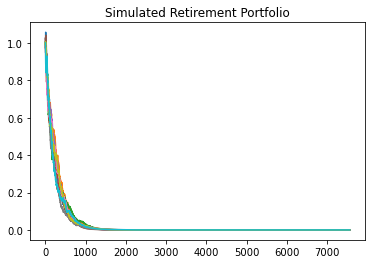

In [9]:
# Visualize the Simulation
monte_carlo.plot(legend=None, title="Simulated Retirement Portfolio")
